In [96]:
from matplotlib import pyplot as plt
from fealpy.backend import backend_manager as bm
from fealpy.mesh import TriangleMesh,UniformMesh2d
from fealpy.functionspace.lagrange_fe_space import LagrangeFESpace
from fealpy.decorator import cartesian, barycentric
from fealpy.functional import integral
from fealpy.utils import process_coef_func
from fealpy.solver import spsolve,cg
from fealpy.fem import BilinearForm, ScalarDiffusionIntegrator
from fealpy.fem import LinearForm, InterFaceSourceIntegrator,ScalarSourceIntegrator
from fealpy.fem import DirichletBC
import torch
def show_function(self, plot, uh, cmap=None):
        """
        """
        from types import ModuleType
        import matplotlib.colors as colors
        import matplotlib.cm as cm
        from mpl_toolkits.mplot3d import Axes3D
        if isinstance(plot, ModuleType):
            fig = plot.figure()
            fig.set_facecolor('white')
            axes = plot.axes(projection='3d')
        else:
            axes = plot

        node = self.node
        cell = self.cell
        node = node.cpu()
        cell = cell.cpu()
        
        cax = axes.plot_trisurf(
            node[:, 0], node[:, 1],
            uh, triangles=cell, cmap=cmap, lw=0.0)
        axes.figure.colorbar(cax, ax=axes)
        return axes

In [97]:
# interface level function
def interface(p):
    x = p[...,0]
    y = p[...,1]
    return x**2 + y**2-(2.1)**2

In [ ]:
class interfacefunction:
    def __init__(self, kappa=1.0):
        self.kappa = kappa 

    def domain(self):
        return [0, 10, -10, 10]
    
    @cartesian
    def solution(self, p):
        """  
        @brief 模型真解
        """
        x = p[..., 0]
        y = p[..., 1]
        pi = bm.pi

        val = bm.zeros(x.shape,dtype=bm.float64)

        Omega0 = interface(p)>=0 #Omega+
        Omega1 = interface(p)<0 #Omega-
        
        val[Omega0] = -x[Omega0] + 2.1**2*x[Omega0]/(x[Omega0]**2+y[Omega0]**2)
        val[Omega1] = 0

        return val

    @cartesian
    def grad_solution(self, p):
        """  
        @brief 模型真解
        """
        x = p[..., 0]
        y = p[..., 1]
        pi = bm.pi

        # val = bm.zeros(x.shape,dtype=bm.float64)
        grad0 = bm.zeros(x.shape,dtype=bm.float64)
        grad1 = bm.zeros(x.shape,dtype=bm.float64)
        Omega0 = interface(p)>=0 #Omega+
        Omega1 = interface(p)<0 #Omega-
        
        grad0[Omega0] = -1 + 2.1**2*(-x[Omega0]**2+y[Omega0]**2)/(x[Omega0]**2+y[Omega0]**2)**2
        grad0[Omega1] = 0

        grad1[Omega0] = -2*2.1**2*(y[Omega0]*x[Omega0])/(x[Omega0]**2+y[Omega0]**2)**2
        grad1[Omega1] = 0

        return bm.stack((grad0, grad1), axis=-1)

    @cartesian
    def source(self, p):
        """ 
        @brief 源项
        """
        x = p[..., 0]
        y = p[..., 1]
        pi = bm.pi

        val = bm.zeros(x.shape,dtype=bm.float64)

        Omega0 = interface(p)>=0 #Omega -
        Omega1 = interface(p)<0  #Omega +
        
        # val[Omega0] += (-(x[Omega0]**2+y[Omega0]**2)*bm.exp(x[Omega0]*y[Omega0])) # - \Delta u-
        # val[Omega1] += 2*pi**2*bm.sin(pi*x[Omega1])*bm.sin(pi*y[Omega1])  # - \Delta u+
                
        return val 
    @cartesian
    def gN(self,p, n ):
        x = p[..., 0]
        y = p[..., 1]
        pi = bm.pi


        n2 = bm.zeros(p.shape,dtype=bm.float64)
        n2 = 2*x/2.1

        return n2


In [99]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, p):
        return self.net(p)


bm.set_backend("pytorch")
# bm.set_default_device("cuda")
# setup_seed(88888) #变系数
setup_seed(8888) #1gN50

loss = torch.nn.MSELoss()
u = MLP().double()
# opt = torch.optim.Adam(params=u.parameters(),lr = 0.0001)
opt = torch.optim.Adam(params=u.parameters(),lr=0.002) #1gN50
# opt = torch.optim.SGD(u.parameters(), lr=0.00001, momentum=0.9, nesterov=True)

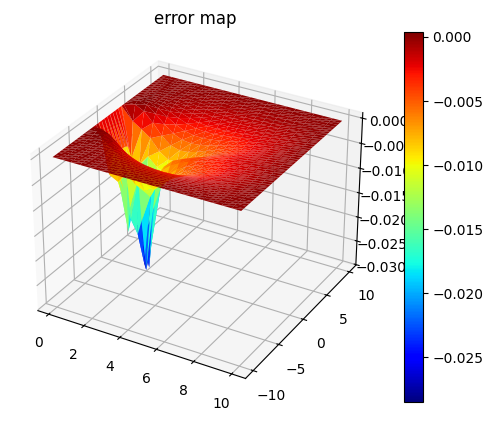

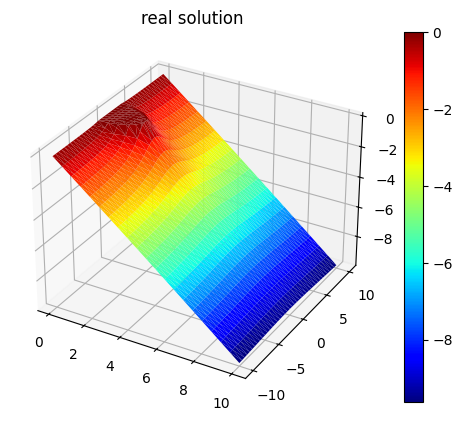

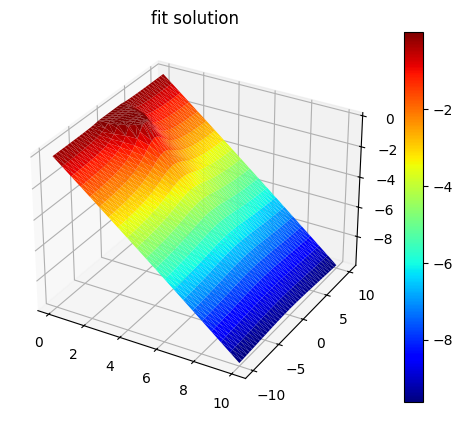

In [100]:

p=1
pde = interfacefunction()  
domain = pde.domain()
h =0.5 
nx = 20
ny = 40
hx = (domain[1] - domain[0])/nx
hy = (domain[3] - domain[2])/ny

back_mesh = UniformMesh2d((0, nx, 0, ny), h=(hx, hy), origin=(domain[0], domain[2]))
iCellNodeIndex, cutNode, auxNode, isInterfaceCell = back_mesh.find_interface_node(interface)
mesh = TriangleMesh.interfacemesh_generator(back_mesh, interface)

cell = mesh.cell
node = mesh.node
edge = mesh.edge

vertex = node[cell,:]
bc = bm.array([1/3,1/3,1/3],dtype=bm.float64)
central_value = bm.einsum("c,qcd->qd",bc,vertex)
adjCell = mesh.face_to_cell()

isInterfaceCell = interface(central_value)
isInterfaceEdge=(isInterfaceCell[adjCell][:,0]*isInterfaceCell[adjCell][:,1])<=0

space= LagrangeFESpace(mesh, p=p)
uh = space.function() # 建立一个有限元函数


cm = mesh.entity_measure('cell')
cqf = mesh.quadrature_formula(4, 'cell')
bcs1, ws1 = cqf.get_quadrature_points_and_weights()
val_pde = process_coef_func(pde.solution, bcs=bcs1, mesh=mesh, etype='cell', index=slice(None, None, None), n=1)
grad_pde = process_coef_func(pde.grad_solution, bcs=bcs1, mesh=mesh, etype='cell', index=slice(None, None, None), n=1)


fm = mesh.entity_measure('face', index=isInterfaceEdge)
qf = mesh.quadrature_formula(4, 'face')
bcs, ws = qf.get_quadrature_points_and_weights()
ps = mesh.bc_to_point(bcs, index=isInterfaceEdge)

Q = 8.4

bform = BilinearForm(space)
bform.add_integrator(ScalarDiffusionIntegrator())
A_without_apply = bform.assembly()

lform = LinearForm(space)
lform.add_integrator(InterFaceSourceIntegrator(pde.gN, threshold=isInterfaceEdge))
F1 = lform.assembly()

lform1 = LinearForm(space)
lform1.add_integrator(ScalarSourceIntegrator(pde.source))
F_without_apply = lform1.assembly()

F2 =  F1 + F_without_apply

A1, F2 = DirichletBC(space, gd = pde.solution).apply(A_without_apply, F2)

A1 = A1.to_dense()

uh = torch.linalg.solve(A1, F2)

error = uh-pde.solution(mesh.node)

axes = show_function(mesh,plt,error.cpu(),cmap='jet')
plt.title("error map")
axes2 = show_function(mesh,plt,pde.solution(mesh.node).cpu(),cmap='jet')
plt.title("real solution ")
axes3 = show_function(mesh,plt,uh.cpu(),cmap='jet')
plt.title("fit solution")

plt.show()



In [101]:
import time
ns = 50

gNNode = bm.unique(edge[isInterfaceEdge].reshape(-1,1))
idxUh = torch.randint(0,mesh.node.shape[0],(1,ns))
idxIn = gNNode[torch.randint(0,gNNode.shape[0],(1,ns))]
MinusgNNode = gNNode[interface(mesh.node[gNNode]) <= 0]
# idxIn = gNNode

tol = 1e-3

global u1
global ers
global iter_times


u1 = bm.zeros(mesh.node.shape[0])
u2 = 0
def l1(val):
    global u1
    global ers
    global iter_times
    uh1 = space.function() # 建立一个有限元函数
    lform = LinearForm(space)
    lform.add_integrator(InterFaceSourceIntegrator(val, threshold=isInterfaceEdge))
    F2 = lform.assembly()

    F4 = F2 + F_without_apply
    A2, F4 = DirichletBC(space, gd = pde.solution).apply(A_without_apply, F4)
    A2 = A2.to_dense()
    
    uh1 = torch.linalg.solve(A2, F4) 
    
    ers = bm.max(bm.abs(uh1 - u1))

    allers = integral((space.value(uh1, bcs1)-val_pde)**2,ws1,cm) + integral((bm.einsum('ijk, ijk -> ij', grad_pde-space.grad_value(uh1, bcs1), grad_pde-space.grad_value(uh1, bcs1))), ws1, cm) 

    # if iter_times % 100 ==0:
    print("ers", ers)
    print("energy norm", allers)
    print("zeros", bm.sum(bm.abs(uh1[MinusgNNode])**2)/MinusgNNode.shape[0])
    

    # if allers < 0.23:
    #     ers = 0

    # if iter_times == 1164:
    # print("energy norm", allers)
    # print("bm", bm.sum(bm.abs(uh1[MinusgNNode])**2)/MinusgNNode.shape[0])
    u1 = uh1

    error = bm.sum(bm.abs(uh1[idxIn] - pde.solution(mesh.node)[idxIn])) + bm.abs(Q - integral(val[...,0], ws, fm))
    return error


epochs = 20000

In [102]:
import time
qf = mesh.quadrature_formula(4, 'face')
bcs, _ = qf.get_quadrature_points_and_weights()
ps = mesh.bc_to_point(bcs, index=isInterfaceEdge)

ers = 1
iter_times = 0
start_time = time.time()
while ers > tol:
    iter_times = iter_times + 1
# for i in range(epochs):
    opt.zero_grad()
    val = u.forward(ps)

    l = l1(val)
    print("times ", time.time()-start_time, " epochs",iter_times," loss: ",l)
    print("==========================================")
    l.backward()

    opt.step()


ers tensor(9.7795, dtype=torch.float64, grad_fn=<MaxBackward1>)
energy norm tensor(47.7321, dtype=torch.float64, grad_fn=<AddBackward0>)
zeros tensor(3.1280, dtype=torch.float64, grad_fn=<DivBackward0>)
times  0.01928424835205078  epochs 1  loss:  tensor(76.3898, dtype=torch.float64, grad_fn=<AddBackward0>)
ers tensor(0.1222, dtype=torch.float64, grad_fn=<MaxBackward1>)
energy norm tensor(42.0637, dtype=torch.float64, grad_fn=<AddBackward0>)
zeros tensor(2.7589, dtype=torch.float64, grad_fn=<DivBackward0>)
times  0.039192914962768555  epochs 2  loss:  tensor(71.6761, dtype=torch.float64, grad_fn=<AddBackward0>)
ers tensor(0.1224, dtype=torch.float64, grad_fn=<MaxBackward1>)
energy norm tensor(36.7491, dtype=torch.float64, grad_fn=<AddBackward0>)
zeros tensor(2.4126, dtype=torch.float64, grad_fn=<DivBackward0>)
times  0.05523943901062012  epochs 3  loss:  tensor(66.9560, dtype=torch.float64, grad_fn=<AddBackward0>)
ers tensor(0.1228, dtype=torch.float64, grad_fn=<MaxBackward1>)
energy n

In [103]:
print(iter_times)

148


误差高点的个数: tensor(39)
高误差点的拟合值: tensor([-0.0094, -0.0072, -0.0068, -0.0068, -0.0068, -0.0068, -0.0068, -0.0072,
        -0.0094, -0.0132, -0.0131, -0.0135, -0.0137, -0.0135, -0.0131, -0.0132,
        -0.0189, -0.0204, -0.0208, -0.0204, -0.0189, -0.0279, -0.0099, -0.0099,
        -0.0210, -0.0210, -0.0216, -0.0280, -0.0280, -0.0216, -0.0280, -0.0096,
        -0.0096, -0.0110, -0.0110, -0.0184, -0.0184, -0.0295, -0.0295],
       dtype=torch.float64)
高误差点的真实值: tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -8.6590e-11, -8.6590e-11,  0.0000e+00,
         0.0000e+00, -9.0825e-10,  0.0000e+00,  0.0000e+00, -9.0825e-10,
         0.0000e+00, -1.5787e-09, -1.5787e-09, -6.9115e-10, -6.9115e-10,
         0.0000e+00,  0.0000e

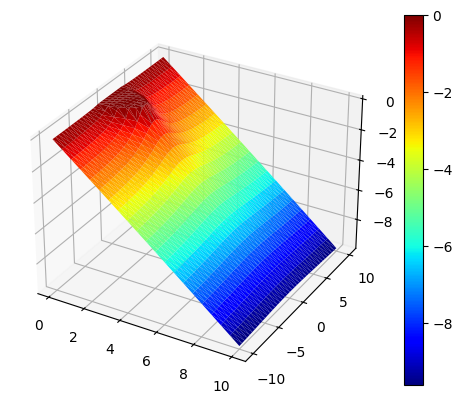

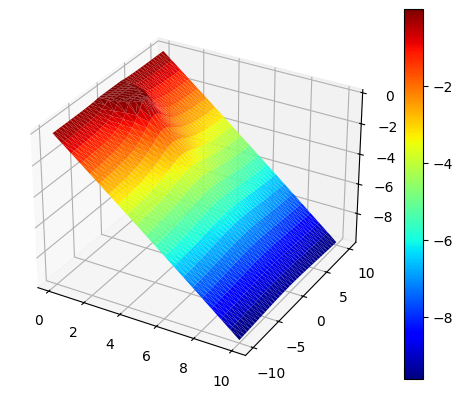

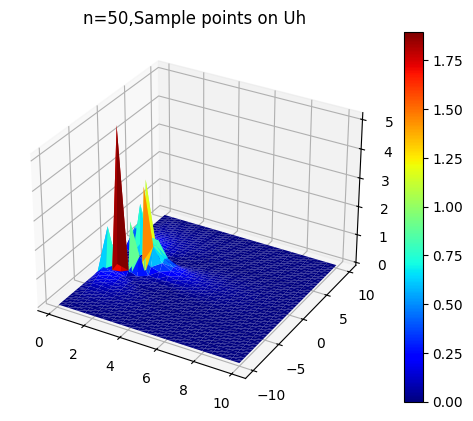

In [104]:
import numpy as np

eps = 1e-9
uh1 = space.function() # 建立一个有限元函数

lform = LinearForm(space)
lform.add_integrator(InterFaceSourceIntegrator(u.forward(ps),threshold=isInterfaceEdge))
F2 = lform.assembly()

F4 = F2 + F_without_apply

A2, F4 = DirichletBC(space, gd = pde.solution).apply(A_without_apply, F4)

A2 = A2.to_dense()

uh1 = torch.linalg.solve(A2, F4)
uh1 = uh1
uh3 = uh1.detach()

relative_error = (bm.abs(uh3-pde.solution(mesh.node)))/(bm.abs(pde.solution(mesh.node))+eps)*100
error1 = relative_error.cpu()


maxidx = bm.abs(error1) > 10000
print("误差高点的个数:",bm.sum(maxidx))
print("高误差点的拟合值:",uh[maxidx])
print("高误差点的真实值:",pde.solution(mesh.node)[maxidx])
error1[maxidx] = 0

axes = show_function(mesh,plt,uh3,cmap='jet')
axes = show_function(mesh,plt,uh,cmap='jet')
axes = show_function(mesh,plt,error1,cmap='jet')

plt.title(f"n={ns},Sample points on Uh")
plt.show()
 

In [105]:
#输出uh的error最大值及其对应坐标

maxidx = bm.where(bm.abs(error1)==bm.max(bm.abs(error1)))
print("最大误差所在的网格节点:",maxidx)
print("uh最大相对误差:",error1[maxidx])
print("最大误差所在真实值: uh = ",uh[maxidx])
print("最大误差所在拟合值: uh_hat =",uh3[maxidx])
print("uh平均误差",bm.sum(bm.abs(error1))/error1.shape[0])
print("L2",bm.sqrt(bm.sum(bm.abs(error1)**2))/bm.sqrt(bm.sum(pde.solution(mesh.node)**2)))

最大误差所在的网格节点: (tensor([98]),)
uh最大相对误差: tensor([5.1248], dtype=torch.float64)
最大误差所在真实值: uh =  tensor([-0.1742], dtype=torch.float64)
最大误差所在拟合值: uh_hat = tensor([-0.1719], dtype=torch.float64)
uh平均误差 tensor(0.0556, dtype=torch.float64)
L2 tensor(0.0495, dtype=torch.float64)


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

def gN_scatter(mesh,gNNode,pred,real, filter = False):
    x = mesh.node[gNNode, 0].cpu().detach().numpy().reshape(-1,1).flatten()  # 将 x 移到 CPU 并转换为 NumPy 数组
    y = mesh.node[gNNode, 1].cpu().detach().numpy().reshape(-1,1).flatten()  # 将 y 移到 CPU 并转换为 NumPy 数组

    # x1 = mesh.node[idxIn][...,0].cpu()
    # y1 = mesh.node[idxIn][...,1].cpu()

    relative_error = ((pred - real)/(real+1e-9)*100).cpu().detach().numpy().flatten()
    
    maxidx = np.where(np.abs(relative_error) > 100)

    print("误差较高的点个数有：",maxidx)
    print("误差较高的点的真实值为:",real[maxidx].reshape(1,-1))
    print("误差较高的点的拟合值为:",pred[maxidx].reshape(1,-1))
    print("高误差为:",relative_error[maxidx])
    
    if filter:
        relative_error[maxidx] = 0

    print("最大误差为:",np.max(np.abs(relative_error)))
    print("平均误差为:",np.sum(np.abs(relative_error))/relative_error.shape[0])
    print("L2",np.sqrt(np.sum(relative_error**2))/bm.sqrt(bm.sum(real**2)))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(x, y, relative_error, c=relative_error, cmap='viridis', marker='o')
# sc = ax.scatter(x1, y1, x1+y1, c='red', cmap='viridis', marker='o')
    cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Relative Error(%)')

    ax.set_title('Relative Error in gN')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')

    plt.show()
    return relative_error

real = pde.gN(mesh.node[gNNode],1).cpu().reshape(-1,1)
pred = u(mesh.node[gNNode,:]).cpu().reshape(-1,1)

误差较高的点个数有： (array([10]),)
误差较高的点的真实值为: tensor([[0.0952]], dtype=torch.float64)
误差较高的点的拟合值为: tensor([[0.2452]], dtype=torch.float64, grad_fn=<ViewBackward0>)
高误差为: [157.4847794]
最大误差为: 157.4847794047573
平均误差为: 12.318668672456965
L2 tensor(26.3946, dtype=torch.float64)


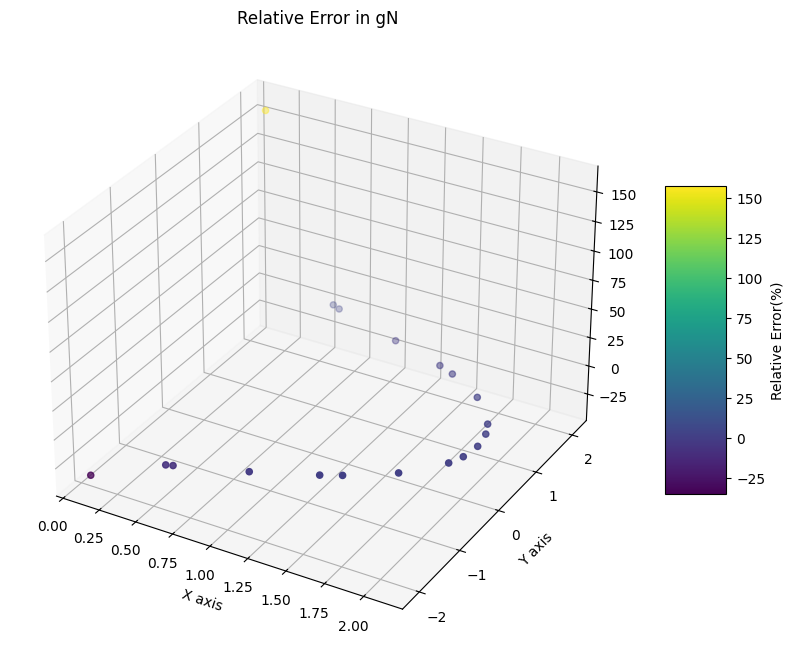

array([-7.60991712e+00,  3.83569821e+00,  1.09864453e+00, -6.66647224e-01,
        1.49100937e+00,  1.11931844e+00,  1.74972466e+00,  1.47899223e+00,
        1.28153912e+00, -3.47430352e+01,  1.57484779e+02, -8.41616572e+00,
        5.50430242e+00, -1.50714740e+00, -1.91809781e+00,  1.43639518e+00,
        3.33098293e-02,  1.11217292e+00,  1.56780794e+00])

: 

In [ ]:
gN_scatter(mesh,gNNode,pred,real,False)
